# Projeto para o mestrado
Rodrigo Mattos Scavassin

O projeto visa melhores formas de prever uma série temporal com deriva de conceito. A base de dados extraída pelo SCDE e representa o consumo de energia elétrica de uma instituição de ensino entre os períodos de maio de 2022 até agosto de 2025. Os dados levantados são horários.

# Criando o dataset

In [1]:
# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import DBSCAN
from sklearn import tree
import random

In [2]:
pip install river

In [3]:
# Leitura da base de dados
df = pd.read_csv('/eletricidade.csv')

# Converter a coluna de data para o tipo datetime (ajuste o nome da coluna se necessário)
df['data'] = pd.to_datetime(df['data'])

df

,data,hora,consumo
0,2022-05-01,0,535.2
1,2022-05-01,1,530.4
2,2022-05-01,2,535.2
3,2022-05-01,3,534.0
4,2022-05-01,4,584.4
...,...,...,...
29250,2025-08-31,19,603.6
29251,2025-08-31,20,590.4
29252,2025-08-31,21,596.4
29253,2025-08-31,22,576.0


In [4]:
# Leitura do acréscimo
path = ''
if path:
  aumento = pd.read_csv(path)
  df['consumo'] = df['consumo'] * aumento['valor']

df

,data,hora,consumo
0,2022-05-01,0,535.2
1,2022-05-01,1,530.4
2,2022-05-01,2,535.2
3,2022-05-01,3,534.0
4,2022-05-01,4,584.4
...,...,...,...
29250,2025-08-31,19,603.6
29251,2025-08-31,20,590.4
29252,2025-08-31,21,596.4
29253,2025-08-31,22,576.0


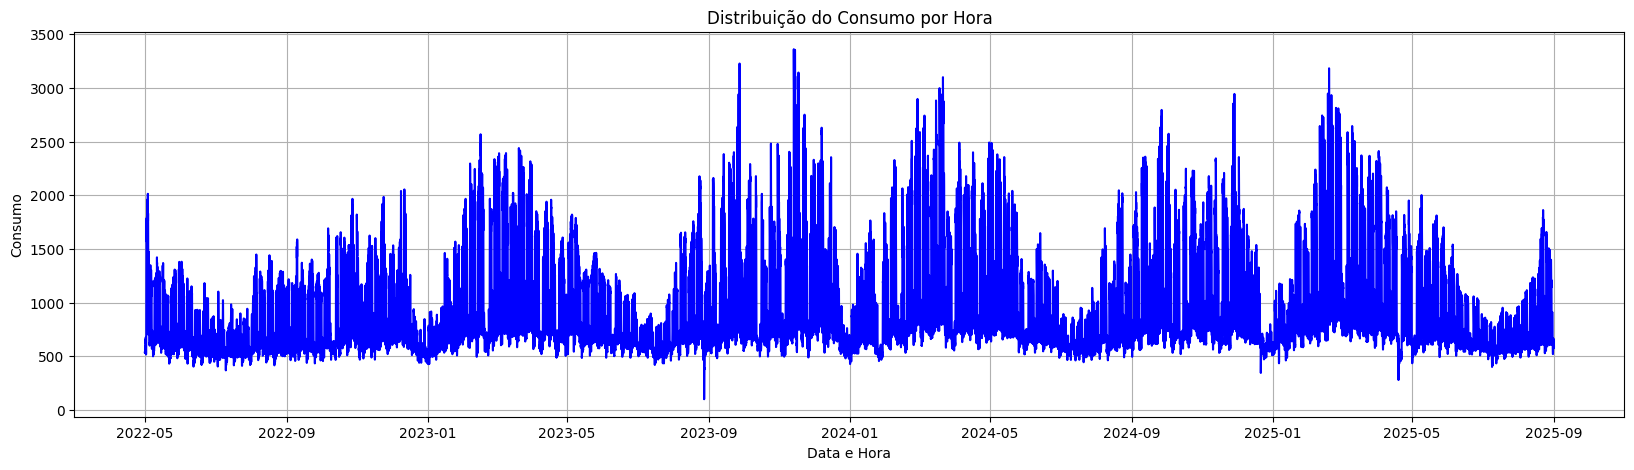

Dataframe exportado para 'distribuicao_consumo.csv'


In [5]:
# Plotar gráfico de linha
df['datetime'] = pd.to_datetime(df['data'].astype(str) + ' ' + df['hora'].astype(str) + ':00')
plt.figure(figsize=(20, 5))
plt.plot(df['datetime'], df['consumo'], linestyle='-', color='blue')
plt.title('Distribuição do Consumo por Hora')
plt.xlabel('Data e Hora')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()

# Exportar para CSV
df.to_csv('distribuicao_consumo.csv', index=False)
print("Dataframe exportado para 'distribuicao_consumo.csv'")

## Previsão dos próximos 15 dias (hora a hora) com retreinamento por deriva (ADWIN)

**Objetivo**: a partir de um modelo treinado com os **primeiros 365 dias**, realizar previsões **hora a hora** e, diariamente às 00:00, executar uma **previsão recursiva de 15 dias** (360 horas) usando como entrada apenas o **dia anterior (lag-24)** e **características de calendário** (*hora*, *dia da semana*, *mês*). Em caso de **detecção de deriva** (ADWIN) no erro absoluto, **retreinar** o modelo com os **últimos 365 dias**.

**Saídas geradas**:
- `resultados_stream_hourly.csv` — Previsão 1-passo (hora a hora) vs. real.
- `relatorio_janelas_15d.csv` — Soma prevista × soma real por janela de 15 dias (início diário 00:00).
- `eventos_deriva.csv` — Log de eventos de deriva (retreinamentos ADWIN).
- Gráficos opcionais são salvos como PNG.


In [6]:
# Imports para a nova seção
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from river.drift import ADWIN
import math, warnings
warnings.filterwarnings('ignore')


In [7]:
# Funções auxiliares
def _ensure_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    cols = {c.lower(): c for c in df.columns}
    # tenta montar timestamp se houver 'data' e 'hora'
    if 'timestamp' in cols:
        out = df.rename(columns={cols['timestamp']:'timestamp', cols.get('consumo','consumo'):'consumo'}).copy()
        out['timestamp'] = pd.to_datetime(out['timestamp'], errors='coerce')
        out = out.dropna(subset=['timestamp','consumo']).sort_values('timestamp').reset_index(drop=True)
        return out[['timestamp','consumo']]
    if 'data' in cols and 'hora' in cols and 'consumo' in cols:
        out = df.rename(columns={cols['data']:'data', cols['hora']:'hora', cols['consumo']:'consumo'}).copy()
        out['data'] = pd.to_datetime(out['data'], errors='coerce')
        out['hora'] = pd.to_numeric(out['hora'], errors='coerce').astype('Int64')
        out = out.dropna(subset=['data','hora','consumo'])
        out['timestamp'] = out['data'] + pd.to_timedelta(out['hora'].astype(int), unit='h')
        out = out[['timestamp','consumo']].sort_values('timestamp').reset_index(drop=True)
        return out
    raise ValueError("Não encontrei colunas compatíveis. Esperado: ['data','hora','consumo'] ou ['timestamp','consumo'].")

def make_features(ts: pd.Series) -> pd.DataFrame:
    return pd.DataFrame({
        'hora': ts.dt.hour.astype(int),
        'dia_semana': ts.dt.dayofweek.astype(int),
        'mes': ts.dt.month.astype(int),
    }, index=ts)

def build_design_matrix(df_th: pd.DataFrame) -> pd.DataFrame:
    feats = make_features(df_th['timestamp'])
    feats['lag168'] = df_th['consumo'].shift(168).values
    feats['y'] = df_th['consumo'].values
    return feats.reset_index(drop=True)

def recursive_forecast_15d(model, history_df: pd.DataFrame, start_pos: int):
    horizon = 15 * 24  # 360 horas
    work = history_df[['timestamp','consumo']].copy().set_index('timestamp')
    start_time = work.index[start_pos]
    future_index = pd.date_range(start_time, periods=horizon, freq='H')
    series = work['consumo'].copy()
    preds = []
    for ts in future_index:
        lag_ts = ts - pd.Timedelta(hours=168)
        lag168 = series.loc[lag_ts] if lag_ts in series.index else series.iloc[-1]
        X = np.array([[ts.hour, ts.dayofweek, ts.month, lag168]])
        yhat = float(model.predict(X)[0])
        preds.append(yhat)
        series.loc[ts] = yhat  # usa previsão quando não houver valor real
    return np.array(preds), future_index


In [8]:
# Execução: usa o 'df' já criado anteriormente no notebook
df_ts = _ensure_timestamp(df)
df_ts['consumo'] = pd.to_numeric(df_ts['consumo'], errors='coerce')
df_ts = df_ts.dropna(subset=['consumo']).reset_index(drop=True)
print(df_ts['timestamp'].dtype)
print(df_ts.head())
sum_pred_list = []
sum_real_list = []

# Matriz de design
design = build_design_matrix(df_ts)
hours_per_year = 365 * 24
start_idx = hours_per_year + 24
if len(design) < start_idx + 360:
    raise ValueError('Dados insuficientes para processar: é necessário >= 365 dias + 24h + 360h.')

train_slice = design.iloc[24:hours_per_year+24].dropna(subset=['lag168'])
X_train = train_slice[['hora','dia_semana','mes','lag168']].values
y_train = train_slice['y'].values

model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42)
model.fit(X_train, y_train)

adwin = ADWIN(delta = 0.000000000002)
hourly_preds, hourly_truth, hourly_timestamps = [], [], []
windows_report = []
drift_detectado = []
num_drift = 0

last_start_for_15d = len(df_ts) - (15*24)
for t in range(start_idx, last_start_for_15d):
    ts = df_ts.loc[t,'timestamp']
    row = design.loc[t]
    if np.isnan(row['lag168']):
        continue
    X_t = np.array([[row['hora'], row['dia_semana'], row['mes'], row['lag168']]])
    y_hat = float(model.predict(X_t)[0])
    y_true = float(row['y'])
    hourly_preds.append(y_hat)
    hourly_truth.append(y_true)
    hourly_timestamps.append(ts)
    # deriva por erro absoluto
    loss = abs(y_true - y_hat)
    adwin.update(loss)
    if adwin.drift_detected:
        start_retrain = max(0, t - (365*24))
        retrain_slice = design.iloc[start_retrain:t].dropna(subset=['lag168'])
        num_drift += 1
        drift_detectado.append(t - start_idx)
        if len(retrain_slice) >= 1000:
            X_ret = retrain_slice[['hora','dia_semana','mes','lag168']].values
            y_ret = retrain_slice['y'].values
            model.fit(X_ret, y_ret)
    else:
        drift_detectado.append(None)

    if ts.hour == 0:
        preds_360, fut_index = recursive_forecast_15d(model, df_ts[['timestamp','consumo']], t)
        sum_pred = float(np.sum(preds_360))
        sum_pred_list.append(sum_pred)
        sum_real = float(np.sum(df_ts.iloc[t:t+15*24]['consumo'].values))
        sum_real_list.append(sum_real)
        rmse = math.sqrt(mean_squared_error(sum_pred_list, sum_real_list))
        err_abs = abs(sum_real - sum_pred)
        err_perc = (err_abs / (abs(sum_real)+1e-9)) * 100.0
        windows_report.append([ts, sum_pred, sum_real, err_abs, err_perc, rmse])

import math
from sklearn.metrics import mean_squared_error
rmse_hourly = math.sqrt(mean_squared_error(hourly_truth, hourly_preds)) if len(hourly_preds) else float('nan')
print(f'RMSE (1-passo streaming): {rmse_hourly:.4f}')

import pandas as pd
results = pd.DataFrame({'timestamp':hourly_timestamps,'y_true':hourly_truth,'y_pred':hourly_preds})
report_df = pd.DataFrame(windows_report, columns=['timestamp_inicio','soma_prev_15d','soma_real_15d','erro_abs','erro_perc','rmse'])
results.to_csv('resultados_stream_hourly.csv', index=False)
report_df.to_csv('relatorio_janelas_15d.csv', index=False)
print('Arquivos salvos: resultados_stream_hourly.csv, relatorio_janelas_15d.csv')
print("Número de detecções de deriva: "+ str(num_drift))


datetime64[ns]
            timestamp  consumo
0 2022-05-01 00:00:00    535.2
1 2022-05-01 01:00:00    530.4
2 2022-05-01 02:00:00    535.2
3 2022-05-01 03:00:00    534.0
4 2022-05-01 04:00:00    584.4
RMSE (1-passo streaming): 359.5871
Arquivos salvos: resultados_stream_hourly.csv, relatorio_janelas_15d.csv
Número de detecções de deriva: 34


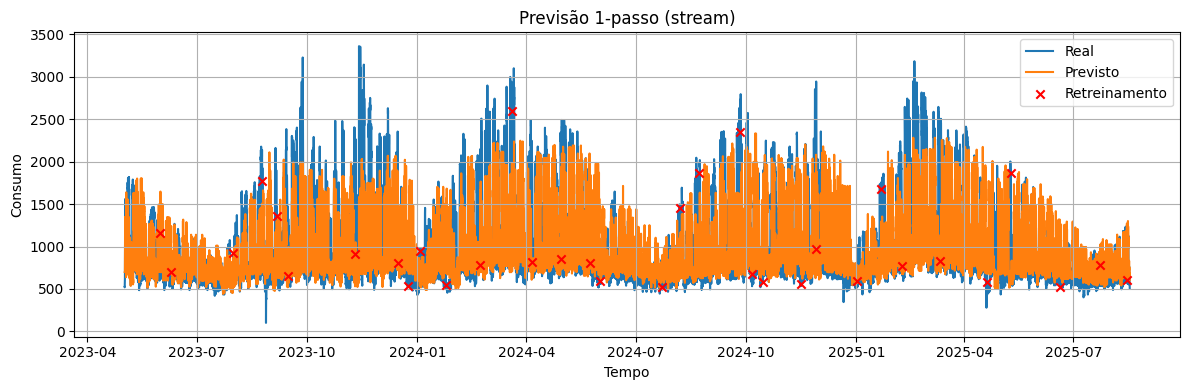

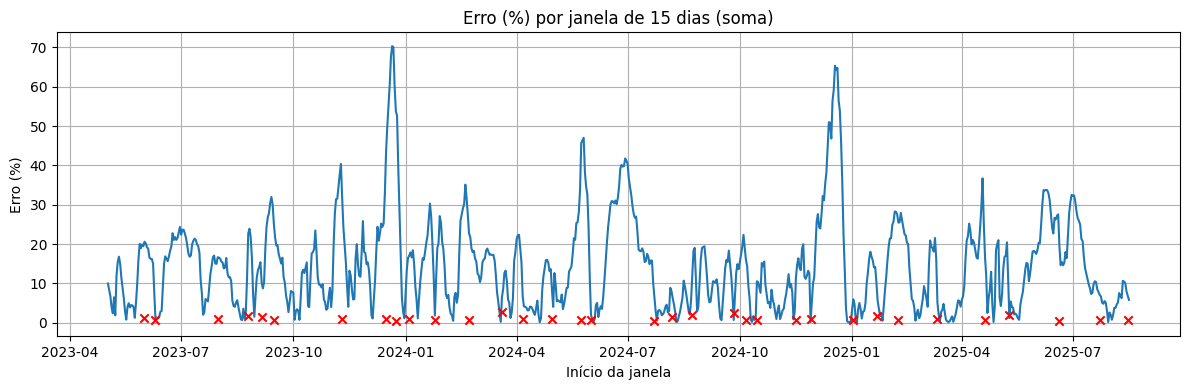

In [9]:
# Gráficos simples (opcional)
# limpa valores inválidos
drift_clean = [d for d in drift_detectado if isinstance(d, int)]

# converte índices para timestamps
drift_timestamps = results.iloc[drift_clean]['timestamp']
drift_values = results.iloc[drift_clean]['y_true']

try:
    plt.figure(figsize=(12,4))
    plt.plot(results['timestamp'], results['y_true'], label='Real', zorder = 1)
    plt.plot(results['timestamp'], results['y_pred'], label='Previsto', zorder = 1)
    plt.scatter(drift_timestamps, drift_values,
            color='red', label='Retreinamento', marker='x', zorder=2)
    plt.title('Previsão 1-passo (stream)')
    plt.xlabel('Tempo'); plt.ylabel('Consumo'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()
except Exception as e:
    print('Plot 1-step falhou:', e)

try:
    if not report_df.empty:
        plt.figure(figsize=(12,4))
        plt.plot(report_df['timestamp_inicio'], report_df['erro_perc'])
        plt.scatter(drift_timestamps, drift_values/1000,
        color='red', label='Retreinamento', marker='x', zorder=2)
        plt.title('Erro (%) por janela de 15 dias (soma)')
        plt.xlabel('Início da janela'); plt.ylabel('Erro (%)'); plt.grid(True)
        plt.tight_layout(); plt.show()
except Exception as e:
    print('Plot 15d falhou:', e)


## VARIAÇÃO 1 — Retreinamento no início do mês (sem ADWIN)

In [10]:
# VARIAÇÃO 1 — Retreinamento no início do mês (Sem ADWIN)

from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import math

model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42)
train_slice = design.iloc[24:hours_per_year+24].dropna(subset=["lag168"])
model.fit(train_slice[['hora','dia_semana','mes','lag168']].values, train_slice['y'].values)

hourly_preds = []
hourly_truth = []
hourly_timestamps = []
windows_report_mensal = []
sum_pred_list = []
sum_real_list = []

last_start_for_15d = len(df_ts) - (15*24)

for t in range(start_idx, last_start_for_15d):
    ts = df_ts.loc[t,'timestamp']
    row = design.loc[t]
    if np.isnan(row['lag168']):
        continue

    X_t = np.array([[row['hora'], row['dia_semana'], row['mes'], row['lag168']]])
    y_hat = float(model.predict(X_t)[0])
    y_true = float(row['y'])

    hourly_preds.append(y_hat)
    hourly_truth.append(y_true)
    hourly_timestamps.append(ts)

    # Retreinamento no 1º dia do mês às 00:00
    if ts.day == 1 and ts.hour == 0:
        start_retrain = max(0, t - (365*24))
        retrain_slice = design.iloc[start_retrain:t].dropna(subset=['lag168'])
        if len(retrain_slice) >= 1000:
            model.fit(retrain_slice[['hora','dia_semana','mes','lag168']].values,
                      retrain_slice['y'].values)

    # Previsão dos 15 dias
    if ts.hour == 0:
        preds_360, fut_index = recursive_forecast_15d(model, df_ts[['timestamp','consumo']], t)
        sum_pred = float(np.sum(preds_360))
        sum_pred_list.append(sum_pred)
        sum_real = float(np.sum(df_ts.iloc[t:t+15*24]['consumo'].values))
        sum_real_list.append(sum_real)
        rmse = math.sqrt(mean_squared_error(sum_pred_list, sum_real_list))
        err_abs = abs(sum_real - sum_pred)
        err_perc = (err_abs/(abs(sum_real)+1e-9))*100
        windows_report_mensal.append([ts,sum_pred,sum_real,err_abs,err_perc, rmse])

report_mensal = pd.DataFrame(windows_report_mensal, columns=['timestamp_inicio','soma_prev_15d','soma_real_15d','erro_abs','erro_perc','rmse'])
report_mensal['metodo'] = 'Retreinamento Mensal'


## VARIAÇÃO 2 — Hoeffding Adaptive Tree (Sem retreinamento)

In [11]:
# INICIALIZAÇÃO

from river.tree import HoeffdingAdaptiveTreeRegressor
import numpy as np
import pandas as pd

model_hat = HoeffdingAdaptiveTreeRegressor(max_depth=10)

windows_report_hat = []
sum_pred_list = []
sum_real_list = []

# PRÉ-TREINAMENTO SEGURO NOS PRIMEIROS 365 DIAS

for t0 in range(24, 365*24 + 24):

    row0 = design.loc[t0]

    # pula linhas incompletas (lag168 ainda não existe ou colunas faltando)
    if (
        pd.isna(row0["lag168"]) or
        pd.isna(row0["hora"]) or
        pd.isna(row0["dia_semana"]) or
        pd.isna(row0["mes"]) or
        pd.isna(row0["y"])
    ):
        continue

    x0 = {
        #"hora": int(row0["hora"]),
        #"dia_semana": int(row0["dia_semana"]),
        #"mes": int(row0["mes"]),
        "lag168": float(row0["lag168"]),
    }
    y0 = float(row0["y"])

    model_hat.learn_one(x0, y0)

In [12]:
# Função de previsão recursiva de 15 dias para o HAT (modelo incremental)
def recursive_forecast_15d_hat(model_hat, history_df, start_pos):
    horizon = 15 * 24  # 360 horas

    # Trabalha com uma série indexada pelo timestamp
    work = history_df[['timestamp','consumo']].copy().set_index('timestamp')
    start_time = work.index[start_pos]

    # Conjunto de timestamps futuros
    future_index = pd.date_range(start_time, periods=horizon, freq="H")

    # Série interna que será alimentada pelas previsões
    series = work['consumo'].copy()
    preds = []

    for ts in future_index:
        # lag-24
        lag_ts = ts - pd.Timedelta(hours=168)
        if lag_ts in series.index:
            lag168 = float(series.loc[lag_ts])
        else:
            lag168 = float(series.iloc[-1])

        # Criação do vetor de atributos no formato do HAT
        x = {
            #"hora": int(ts.hour),
            #"dia_semana": int(ts.dayofweek),
            #"mes": int(ts.month),
            "lag168": lag168,
        }

        # Previsão sem atualização do modelo (importantíssimo!)
        yhat = model_hat.predict_one(x)
        if yhat is None:
            yhat = lag168

        preds.append(yhat)

        # Armazena a previsão para usar como histórico futuro
        series.loc[ts] = yhat

    return np.array(preds), future_index


In [13]:
# VARIAÇÃO 2 — Hoeffding Adaptive Tree (Corrigida)
# Loop streaming (com atualização)
for t in range(start_idx, last_start_for_15d):
    ts = df_ts.loc[t,'timestamp']
    row = design.loc[t]
    if np.isnan(row['lag168']):
        continue

    X_dict = {
        #'hora': row['hora'],
        #'dia_semana': row['dia_semana'],
        #'mes': row['mes'],
        'lag168': row['lag168']
    }

    # Previsão 1-step (se None, usa lag168 como fallback)
    y_pred = model_hat.predict_one(X_dict)
    if y_pred is None:
        y_pred = row['lag168']

    y_true = row['y']

    # Atualiza o modelo SOMENTE no streaming (não nos 15 dias futuros)
    model_hat.learn_one(X_dict, y_true)

    # Previsão dos 15 dias somente quando começa o dia
    if ts.hour == 0:
        preds_360, fut_index = recursive_forecast_15d_hat(model_hat, df_ts, t)

        # Calcula período real baseado em timestamp, não por posição
        start_time = ts
        end_time = ts + pd.Timedelta(hours=360)
        mask = (df_ts['timestamp'] >= start_time) & (df_ts['timestamp'] < end_time)
        sum_real = df_ts.loc[mask, 'consumo'].astype(float).sum()
        sum_real_list.append(sum_real)
        sum_pred = float(np.sum(preds_360))
        if sum_pred > 10*sum_real: sum_pred = sum_real

        if windows_report_hat == []: sum_pred = sum_real

        sum_pred_list.append(sum_pred)
        rmse = math.sqrt(mean_squared_error(sum_pred_list, sum_real_list))

        if windows_report_hat == []: rmse = 0

        err_abs = abs(sum_real - sum_pred)
        err_perc = (err_abs / (abs(sum_real) + 1e-9)) * 100

        windows_report_hat.append([ts, sum_pred, sum_real, err_abs, err_perc, rmse])


report_hat = pd.DataFrame(
    windows_report_hat,
    columns=['timestamp_inicio','soma_prev_15d','soma_real_15d','erro_abs','erro_perc', 'rmse']
)
report_hat['metodo'] = 'Hoeffding Adaptive Tree'
report_hat.head(20)


,timestamp_inicio,soma_prev_15d,soma_real_15d,erro_abs,erro_perc,rmse,metodo
0,2023-05-02,377653.200000,377653.2,0.000000,0.000000,0.000000,Hoeffding Adaptive Tree
1,2023-05-03,430301.454545,373653.6,56647.854545,15.160527,40056.082089,Hoeffding Adaptive Tree
2,2023-05-04,432787.443038,368246.4,64541.043038,17.526592,49579.988104,Hoeffding Adaptive Tree
3,2023-05-05,449195.142857,359964.0,89231.142857,24.788907,61920.760890,Hoeffding Adaptive Tree
4,2023-05-06,453665.095890,343513.2,110151.895890,32.066277,74121.741324,Hoeffding Adaptive Tree
5,2023-05-07,425328.000000,338034.0,87294.000000,25.824030,76474.838042,Hoeffding Adaptive Tree
6,2023-05-08,382191.883200,346587.6,35604.283200,10.272809,72069.480467,Hoeffding Adaptive Tree
7,2023-05-09,443634.203682,340596.0,103038.203682,30.252323,76628.112923,Hoeffding Adaptive Tree
8,2023-05-10,441835.821306,336726.0,105109.821306,31.215238,80293.223774,Hoeffding Adaptive Tree
9,2023-05-11,438318.304147,335076.0,103242.304147,30.811608,82874.597689,Hoeffding Adaptive Tree


## VARIAÇÃO 3 — Últimos 15 dias (Modelo = lag168)

In [14]:
# VARIAÇÃO 3 — Modelo "lag168"

windows_report_lag = []
sum_pred_list = []
sum_real_list = []

for t in range(start_idx, last_start_for_15d):
    ts = df_ts.loc[t,'timestamp']

    if ts.hour == 0:
        preds_360 = []
        series = df_ts[['timestamp','consumo']].set_index('timestamp')['consumo'].copy()
        horizon_idx = pd.date_range(ts, periods=360, freq="H")

        for ts_f in horizon_idx:
            lag_ts = ts_f - pd.Timedelta(hours=168)
            yhat = series.loc[lag_ts] if lag_ts in series.index else series.iloc[-1]
            preds_360.append(yhat)
            series.loc[ts_f] = yhat

        sum_pred = np.sum(preds_360)
        sum_pred_list.append(sum_pred)
        sum_real = np.sum(df_ts.iloc[t:t+360]['consumo'].values)
        sum_real_list.append(sum_real)
        rmse = math.sqrt(mean_squared_error(sum_pred_list, sum_real_list))
        err_abs = abs(sum_real - sum_pred)
        err_perc = (err_abs/(abs(sum_real)+1e-9))*100
        windows_report_lag.append([ts,sum_pred,sum_real,err_abs,err_perc, rmse])

report_lag = pd.DataFrame(windows_report_lag, columns=['timestamp_inicio','soma_prev_15d','soma_real_15d','erro_abs','erro_perc','rmse'])
for i in range(len(report_df)):
    if i >= 168:
        report_lag['soma_prev_15d'][i] = report_df['soma_real_15d'].iloc[i - 15]

report_lag['metodo'] = 'lag168 (Últimos 15 dias)'
report_lag.head(20)


,timestamp_inicio,soma_prev_15d,soma_real_15d,erro_abs,erro_perc,rmse,metodo
0,2023-05-02,341810.4,377653.2,3.584280e+04,9.490930e+00,35842.800000,lag168 (Últimos 15 dias)
1,2023-05-03,345931.2,373653.6,2.772240e+04,7.419278e+00,32040.893976,lag168 (Últimos 15 dias)
2,2023-05-04,349926.0,368246.4,1.832040e+04,4.975038e+00,28218.639406,lag168 (Últimos 15 dias)
3,2023-05-05,353019.6,359964.0,6.944400e+03,1.929193e+00,24683.494086,lag168 (Últimos 15 dias)
4,2023-05-06,358933.2,343513.2,1.542000e+04,4.488910e+00,23129.530566,lag168 (Últimos 15 dias)
5,2023-05-07,368455.2,338034.0,3.042120e+04,8.999450e+00,24496.004200,lag168 (Últimos 15 dias)
6,2023-05-08,358526.4,346587.6,1.193880e+04,3.444670e+00,23123.458330,lag168 (Últimos 15 dias)
7,2023-05-09,408144.0,340596.0,6.754800e+04,1.983229e+01,32221.096699,lag168 (Últimos 15 dias)
8,2023-05-10,414685.2,336726.0,7.795920e+04,2.315212e+01,39976.700776,lag168 (Últimos 15 dias)
9,2023-05-11,416284.8,335076.0,8.120880e+04,2.423593e+01,45801.854375,lag168 (Últimos 15 dias)


In [15]:
periodo = 168 # dia: 24 | semana: 168 | mês: 720 | ano: 8760

consumo_real = report_df['soma_real_15d'].copy()
# Initialize consumo_previsto with NaN values and the same length as consumo_real
sum_pred = [np.nan] * len(consumo_real)

for i in range(len(consumo_real)):
    if i >= periodo:
        sum_pred[i] = consumo_real.iloc[i - periodo]


## COMPARAÇÃO

In [16]:
# Renomear colunas para cada variação
report_df_ = report_df[['timestamp_inicio','soma_prev_15d','soma_real_15d','erro_perc','rmse']].rename(
    columns={'soma_prev_15d':'prev_ADWIN','erro_perc':'erro_ADWIN','rmse':'rmse_ADWIN'}
)

report_mensal_ = report_mensal[['timestamp_inicio','soma_prev_15d','erro_perc','rmse']].rename(
    columns={'soma_prev_15d':'prev_Mensal','erro_perc':'erro_Mensal','rmse':'rmse_Mensal'}
)

report_hat_ = report_hat[['timestamp_inicio','soma_prev_15d','erro_perc', 'rmse']].rename(
    columns={'soma_prev_15d':'prev_HAT','erro_perc':'erro_HAT', 'rmse':'rmse_HAT'}
)

report_lag_ = report_lag[['timestamp_inicio','soma_prev_15d','erro_perc','rmse']].rename(
    columns={'soma_prev_15d':'prev_lag168','erro_perc':'erro_lag168','rmse':'rmse_lag168'}
)

# Unificar pelo timestamp
relatorio_final = report_df_.merge(report_mensal_, on='timestamp_inicio', how='outer')
relatorio_final = relatorio_final.merge(report_hat_, on='timestamp_inicio', how='outer')
relatorio_final = relatorio_final.merge(report_lag_, on='timestamp_inicio', how='outer')

# Ordenar por tempo
relatorio_final = relatorio_final.sort_values('timestamp_inicio')

# Salvar
relatorio_final.to_csv("relatorio_janelas_15d_atualizado.csv", index=False)

print("Arquivo salvo como:")
print("relatorio_janelas_15d_atualizado.csv")
relatorio_final.head()



Arquivo salvo como:
relatorio_janelas_15d_atualizado.csv


,timestamp_inicio,prev_ADWIN,soma_real_15d,erro_ADWIN,rmse_ADWIN,prev_Mensal,erro_Mensal,rmse_Mensal,prev_HAT,erro_HAT,rmse_HAT,prev_lag168,erro_lag168,rmse_lag168
0,2023-05-02,340113.585908,377653.2,9.940235,37539.614092,340113.585908,9.940235,37539.614092,377653.200000,0.000000,0.000000,341810.4,9.490930,35842.800000
1,2023-05-03,342520.756952,373653.6,8.332007,34485.334147,342520.756952,8.332007,34485.334147,430301.454545,15.160527,40056.082089,345931.2,7.419278,32040.893976
2,2023-05-04,343538.612042,368246.4,6.709580,31564.491274,343538.612042,6.709580,31564.491274,432787.443038,17.526592,49579.988104,349926.0,4.975038,28218.639406
3,2023-05-05,346115.049477,359964.0,3.847315,28199.045900,346115.049477,3.847315,28199.045900,449195.142857,24.788907,61920.760890,353019.6,1.929193,24683.494086
4,2023-05-06,351627.790144,343513.2,2.362235,25481.724165,351627.790144,2.362235,25481.724165,453665.095890,32.066277,74121.741324,358933.2,4.488910,23129.530566


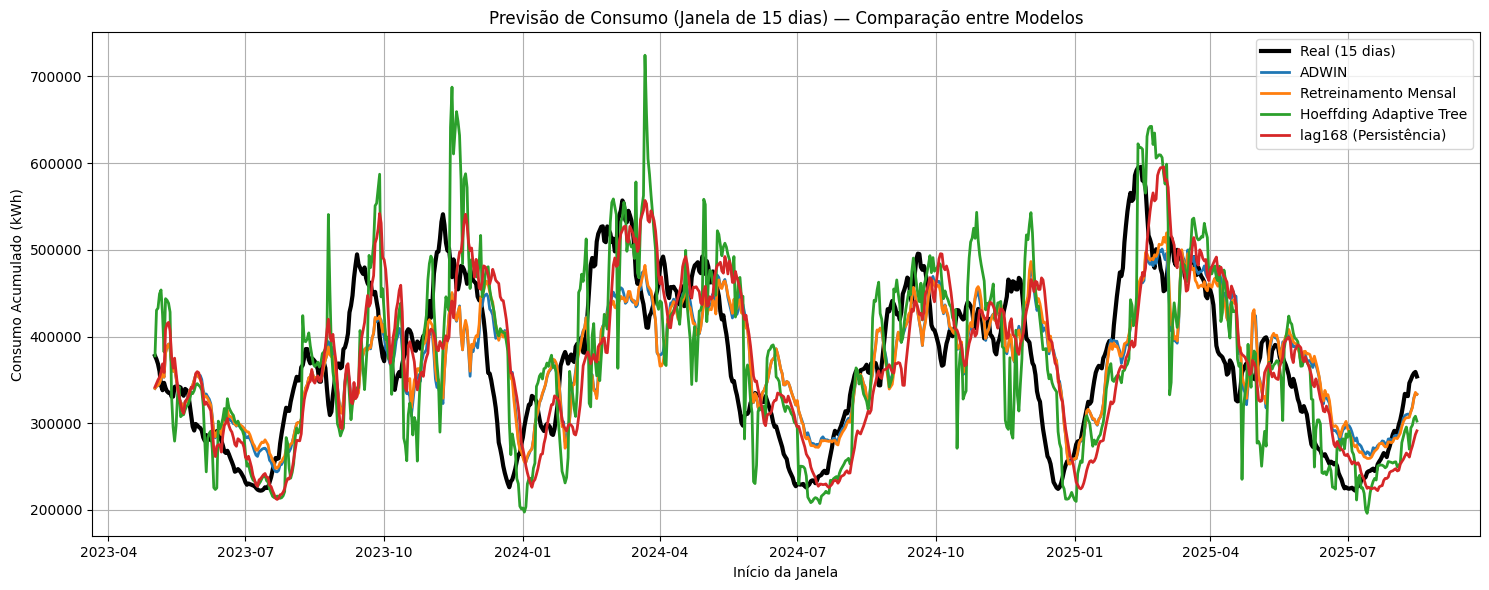

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Carrega o relatório consolidado
relatorio_final = pd.read_csv("relatorio_janelas_15d_atualizado.csv")

# Garantir tipo datetime
relatorio_final['timestamp_inicio'] = pd.to_datetime(relatorio_final['timestamp_inicio'])

# Plot
plt.figure(figsize=(15,6))

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['soma_real_15d'],
         label='Real (15 dias)', linewidth=3, color='black')

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['prev_ADWIN'],
         label='ADWIN', linewidth=2)

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['prev_Mensal'],
         label='Retreinamento Mensal', linewidth=2)

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['prev_HAT'],
         label='Hoeffding Adaptive Tree', linewidth=2)

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['prev_lag168'],
         label='lag168 (Persistência)', linewidth=2)

plt.title('Previsão de Consumo (Janela de 15 dias) — Comparação entre Modelos')
plt.xlabel('Início da Janela')
plt.ylabel('Consumo Acumulado (kWh)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


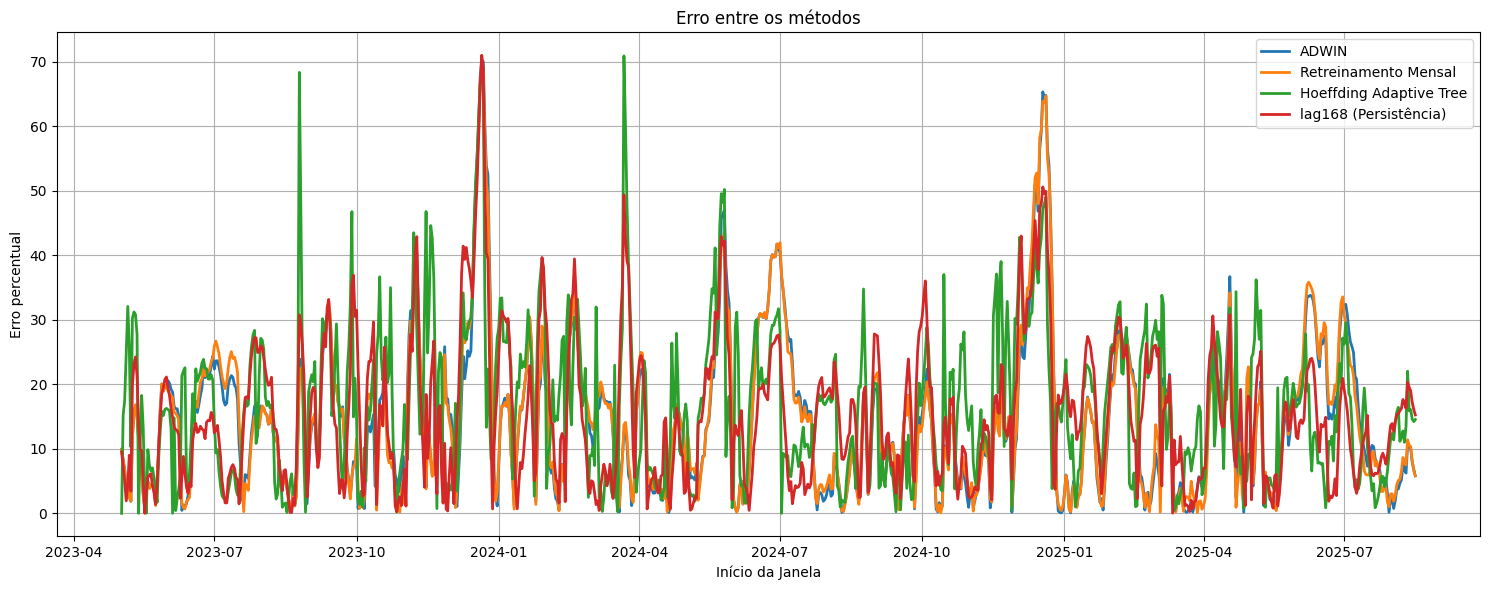

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Carrega o relatório consolidado
relatorio_final = pd.read_csv("relatorio_janelas_15d_atualizado.csv")

# Garantir tipo datetime
relatorio_final['timestamp_inicio'] = pd.to_datetime(relatorio_final['timestamp_inicio'])

# Plot
plt.figure(figsize=(15,6))

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['erro_ADWIN'],
         label='ADWIN', linewidth=2)

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['erro_Mensal'],
         label='Retreinamento Mensal', linewidth=2)

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['erro_HAT'],
         label='Hoeffding Adaptive Tree', linewidth=2)

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['erro_lag168'],
         label='lag168 (Persistência)', linewidth=2)

plt.title('Erro entre os métodos')
plt.xlabel('Início da Janela')
plt.ylabel('Erro percentual')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


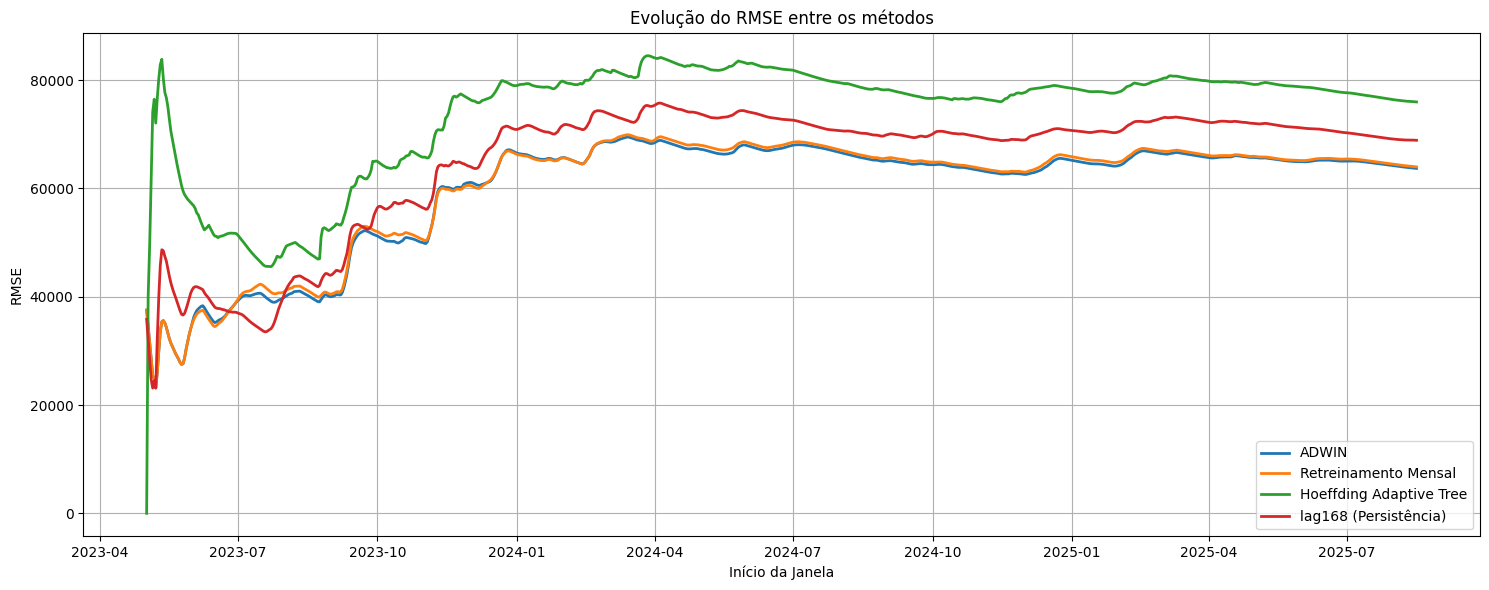

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Carrega o relatório consolidado
relatorio_final = pd.read_csv("relatorio_janelas_15d_atualizado.csv")

# Garantir tipo datetime
relatorio_final['timestamp_inicio'] = pd.to_datetime(relatorio_final['timestamp_inicio'])

# Plot
plt.figure(figsize=(15,6))

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['rmse_ADWIN'],
         label='ADWIN', linewidth=2)

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['rmse_Mensal'],
         label='Retreinamento Mensal', linewidth=2)

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['rmse_HAT'],
         label='Hoeffding Adaptive Tree', linewidth=2)

plt.plot(relatorio_final['timestamp_inicio'], relatorio_final['rmse_lag168'],
         label='lag168 (Persistência)', linewidth=2)

plt.title('Evolução do RMSE entre os métodos')
plt.xlabel('Início da Janela')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()